### Imports



In [1]:
!pip install torchviz

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import numpy as np
import string
import matplotlib.pyplot as plt
from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
seed = 1
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

## Tensors and their Attributes

Tensors themselves are essentially NumPy arrays. They have a particularly special attribute that make them especially useful in deep learning contexts: the gradient.

In [3]:
#Change your runtime type to a GPU to activate "cuda" as a device - will make your code so much faster
device = "cuda" if torch.cuda.is_available() else "cpu"

# Generate tensor from some data, try to always specify dtype to avoid an error
data = [[0, 1, 2, 3], [4, 5, 6, 7]]
tensor = torch.tensor(data, dtype=torch.float32, device=device, requires_grad=True)

print("Tensor:")
print(tensor)

# Shape of the tensor
print("\nShape of the tensor:", tensor.shape)

# Datatype of the tensor
print("Datatype of the tensor:", tensor.dtype)

# Device on which the tensor is stored
print("Device of the tensor:", tensor.device)

# Gradient tracking (requires_grad) of the tensor
print("Gradient tracking of the tensor:", tensor.requires_grad)

Tensor:
tensor([[0., 1., 2., 3.],
        [4., 5., 6., 7.]], device='cuda:0', requires_grad=True)

Shape of the tensor: torch.Size([2, 4])
Datatype of the tensor: torch.float32
Device of the tensor: cuda:0
Gradient tracking of the tensor: True


## The XOR Problem in PyTorch

In lecture, we talked about a barrier to the development of neural networks - **the XOR problem**.

We are now going to show how to solve this in PyTorch! Let's first generate the data.

torch.Size([100, 2])
torch.Size([100])


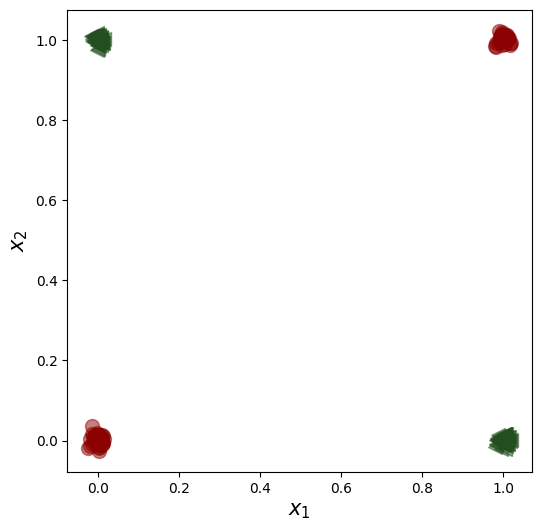

In [4]:
# Setting a seed to make reproducible results
np.random.seed(seed)
torch.manual_seed(seed)

# Generate two random features as 0/1 (indicator variables)
x1 = (np.random.uniform(size=200) < 0.5).astype(int)
x2 = (np.random.uniform(size=200) < 0.5).astype(int)

# Creating the dataset from the features
x = np.array([x1, x2]).T

# Setting up XOR formula
y = x1 + x2 - 2 * x1 * x2
# y_multi = [([0,1] if element == 1 else [0, 1])for element in y]

# Train and test split - use some of the data to train the neural network and
# the rest to validate our results
n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.long)
print(x_train.shape)
print(y_train.shape)
x_test = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_test = torch.tensor(y[n_train:], dtype=torch.long)

# Visualizing our data (adding some jitter)
fig = plt.figure(figsize=(6, 6))
x_jittered = x + np.random.normal(scale=0.009, size=x.shape)
plt.plot(x_jittered[y==0, 0],
         x_jittered[y==0, 1], 'o', alpha=0.5, markersize=10, c='#8b0000')
plt.plot(x_jittered[y==1, 0],
         x_jittered[y==1, 1], '<', alpha=0.5, markersize=10, c='#234f1e')
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)

plt.show()

Now, let's start creating some models to test their ability to solve the XOR problem.

We need to set some hyperparameters first...

In [5]:
# Hyperparameters
input_size = 2 # How many features do we have?
output_size = 2 # 1 signifies binary classification
lr = 0.1 # Factor we will multiply our gradients by in SGD, how much we want to let what we learn change our model parameters
batch_size = 3 # How many examples do you want look at on each update?

In [6]:
# Creating TensorDataset and DataLoader objects from our data
train_ds = TensorDataset(x_train, y_train)
test_ds = TensorDataset(x_test, y_test)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False)

### Adding Non-Linearity to our Model

Well, that did not work! Let us use a **multilayer perceptron with non-linearity** to see how this does!

In [7]:
# Creating our MLP
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(MultiLayerPerceptron, self).__init__()
        self.module_list = nn.ModuleList([ # Accomplishes the same thing but less code
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, output_size),
            nn.LogSoftmax(dim=1)
        ])

    def forward(self, x):
        for layer in self.module_list: # Accomplishes the same thing but less code
            x = layer(x)
        return x

MLP = MultiLayerPerceptron(input_size, output_size, 2).to(device)
MLP

MultiLayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=2, out_features=2, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

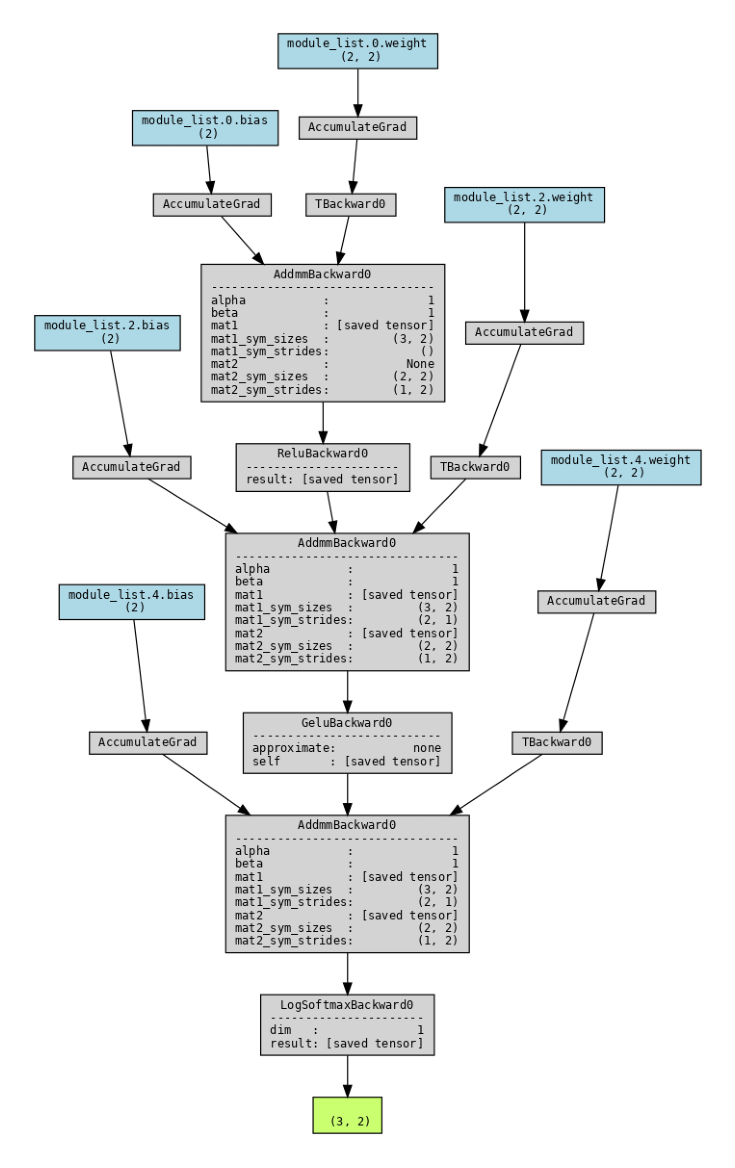

In [8]:
# Let's look at the computational graph for this new model
# How does the hidden size change the model's computational graph?

plt.rcParams['figure.dpi'] = 300
inputs, _ = next(iter(train_dl))
yhat = MLP(inputs.to(device))
graph = make_dot(yhat, params=dict(MLP.named_parameters()), show_attrs=True)

graph.render("viz", format="png")

img = plt.imread("viz.png")
plt.imshow(img)
plt.axis('off')
plt.show()
plt.rcParams['figure.dpi'] = 100

In [9]:
# Resetting our variables!
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(MLP.parameters(), lr=lr)
losses = []

do_once = True
# Training loop
for epoch in range(100):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    num_zeros = 0
    for inputs, labels in train_dl:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = MLP(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        # Check how many gradients are becoming zero in the model
        for param in MLP.parameters():
            if param.grad is not None:
                num_zeros += (param.grad == 0).sum().item()

        predictions = (outputs > 0.5).float()
        correct_predictions += (predictions == labels.view(-1, 1)).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / len(train_dl)
    avg_zero_grads = num_zeros / len(train_dl)

    losses.append(avg_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss}, Average Zero Grads: {avg_zero_grads}")


print("--------------")
print(f"Train Accuracy: {correct_predictions / total_samples}")

Epoch 0, Loss: 23.896083295345306, Average Zero Grads: 5.382352941176471
Epoch 10, Loss: 23.76374325156212, Average Zero Grads: 5.352941176470588
Epoch 20, Loss: 23.749989092350006, Average Zero Grads: 5.294117647058823
Epoch 30, Loss: 23.720813393592834, Average Zero Grads: 5.294117647058823
Epoch 40, Loss: 23.76238489151001, Average Zero Grads: 5.382352941176471
Epoch 50, Loss: 22.58941811323166, Average Zero Grads: 5.264705882352941
Epoch 60, Loss: 11.653421880211681, Average Zero Grads: 6.0588235294117645
Epoch 70, Loss: 9.32473120233044, Average Zero Grads: 5.911764705882353
Epoch 80, Loss: 1.6704404205083847, Average Zero Grads: 5.794117647058823
Epoch 90, Loss: 0.6273846076801419, Average Zero Grads: 5.823529411764706
--------------
Train Accuracy: 0.9


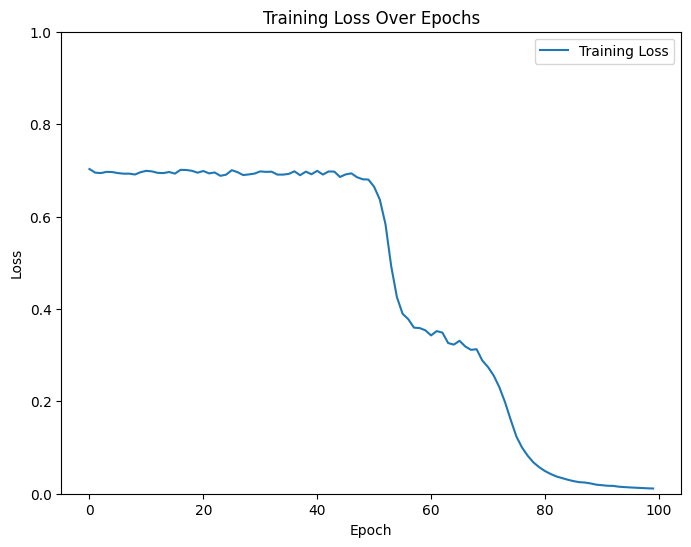

In [10]:
# Plotting the MLP training loss
plt.figure(figsize=(8, 6))
plt.plot(range(100), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.ylim(0, 1)
plt.show()

torch.Size([10000, 2])


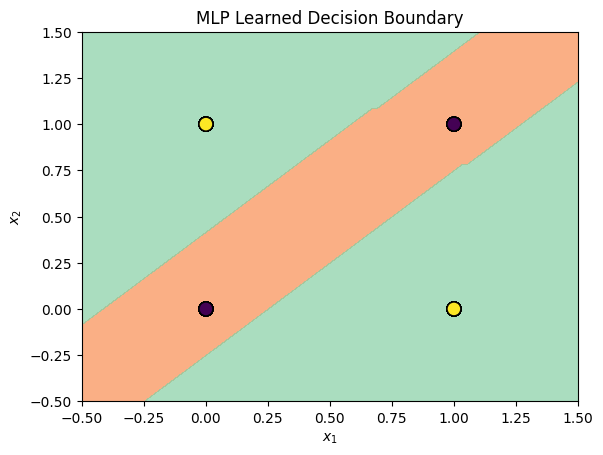

In [11]:
x_min, x_max = -0.5, 1.5
y_min, y_max = -0.5, 1.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Convert grid to tensor and predict using the trained model
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
print(grid.shape)

with torch.no_grad():
    Z = MLP(grid)
    Z = torch.argmax(Z, dim=1).cpu().numpy().reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.7, cmap=plt.cm.Spectral)
plt.scatter(x_test[:, 0],
            x_test[:, 1],
            c=y_test,
            edgecolors='k', marker='o', s=100)
plt.title("MLP Learned Decision Boundary")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

Looks like we did a much better job! Let's make sure by checking our test accuracy...

In [12]:
# Set model to evaluation mode
MLP.eval()

# Initialize a counters for correct and total predictions
correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = MLP(inputs)
        outputs = torch.argmax(outputs, dim=1)

        # Apply a threshold of 0.5 for binary classification and fix the shape
        predicted = (outputs > 0.5).float().squeeze()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)


# Calculate accuracy
accuracy = correct / total

print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 100.00%


In [13]:
import imageio.v2 as imageio
import os
from IPython.display import Image, display

MLP2 = MultiLayerPerceptron(input_size, output_size, 2).to(device)
MLP2

MultiLayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=2, out_features=2, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [14]:
# Resetting our variables!
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(MLP2.parameters(), lr=0.1)
image_files = []

# Training loop
for epoch in range(300):
    total_loss = 0
    for inputs, labels in train_dl:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = MLP2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    #print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dl):.4f}")
    if epoch % 10 == 0:
        with torch.no_grad():
            x_min, x_max = -0.5, 1.5
            y_min, y_max = -0.5, 1.5
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
            grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
            Z = MLP2(grid)
            Z = torch.argmax(Z, dim=1).cpu().numpy().reshape(xx.shape)

            plt.figure()
            plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.7, cmap=plt.cm.Spectral)
            plt.scatter(x_test[:, 0],
                        x_test[:, 1],
                        c=y_test,
                        edgecolors='k', marker='o', s=100)
            plt.title(f"MLP Learned Decision Boundary - Epoch {epoch + 1}")
            plt.xlabel("$x_1$")
            plt.ylabel("$x_2$")

        # Save image
        image_file = f"epoch_{epoch + 1}.png"
        plt.savefig(image_file)
        image_files.append(image_file)
        plt.close()

In [15]:
# Create GIF
gif_file = 'training_progress.gif'
with imageio.get_writer(gif_file, mode='I', duration=0.5) as writer:
    for image_file in image_files:
        image = imageio.imread(image_file)
        writer.append_data(image)

# Clean up images
for image_file in image_files:
    os.remove(image_file)

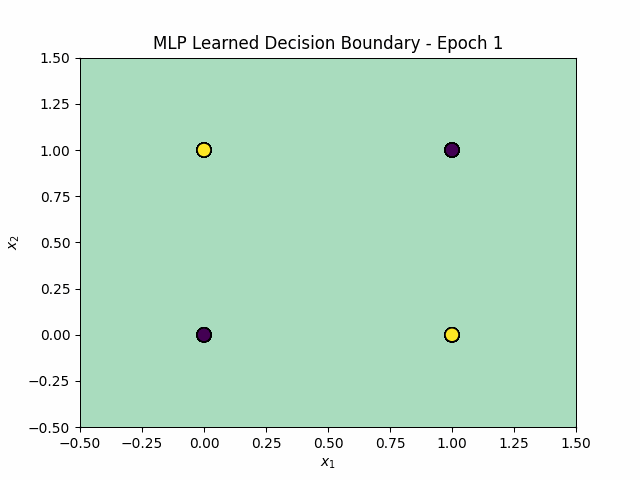

In [16]:
display(Image(filename=gif_file))